In [1]:
import sys
from scipy.io import loadmat, savemat
from math import pi

import matplotlib.pyplot as plt
import torch
import torchaudio

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft.loss import entropy_loss, kurtosis2_loss, kurtosis_loss
from dstft import DSTFT, FDSTFT

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1802);

torch.Size([40000])


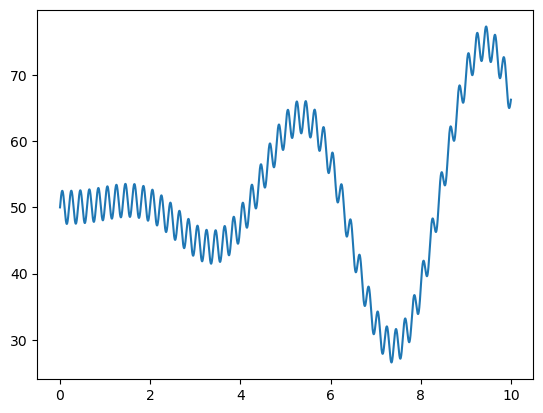

In [2]:
specs = {}
sr = 4_000

def freq(t): 
    f = 25 * torch.sin(1.5*t) * torch.hann_window(2*t.shape[0])[:t.shape[0]] + 50 + 2.5 * torch.sin(10*pi*t)
    return f

t = torch.arange(0, 20, 1/sr)[:int(20*sr/2)]
f = freq(t)
#f = f[:40_000]
#t = t[:40_000]
phase = torch.cumsum(f, dim=0) 
x = torch.sin( 3*pi*phase/sr + 2*pi*torch.rand(t.shape)/sr)
x += torch.sin( 6*2*pi*phase/sr + pi*2*torch.rand(t.shape)/sr)
x += torch.sin( 12*2*pi*phase/sr + 2*pi*2*torch.rand(t.shape)/sr)
x += torch.sin( 24*2*pi*phase/sr + 4*pi*2*torch.rand(t.shape)/sr)
x += 0.05 * torch.randn(x.shape)
x = x[None, ...].to(device)
plt.plot(t, f)
print(f.shape)
support = 750; stride = 100


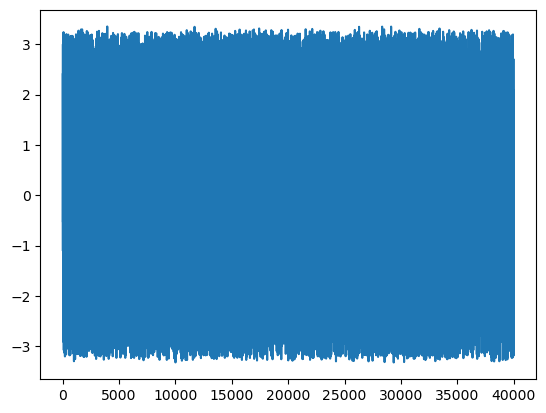

In [3]:
plt.plot(x.squeeze().cpu())

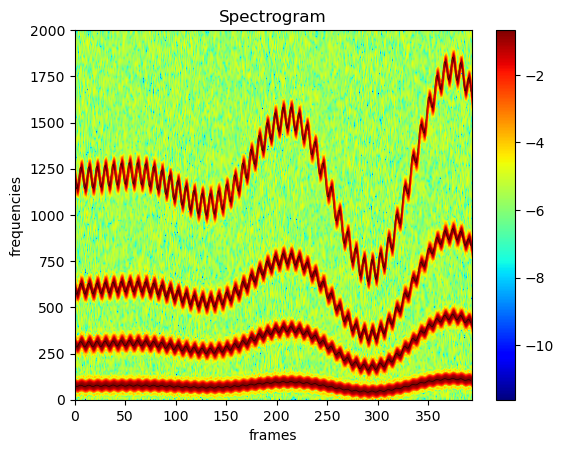

torch.Size([1, 750, 393])


In [4]:
dstft = FDSTFT(x, win_length=200,   support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
f_hat = torch.nn.functional.interpolate(f[None, None, None, int(dstft.N/2):-int(dstft.N/2)], size=spec.shape[-1], mode='bicubic')
f_hat = f_hat.squeeze()[0]
dstft.print(spec, weights=False, wins=False, bar=True, f_hat=[1.5*f_hat, 6*f_hat, 12*f_hat, 24*f_hat], fs=sr)
specs[200] = spec.cpu()
print(stft.shape)

In [5]:
print(stft[0].shape)
ss = fast_SST(stft[0], 10, stft.shape[-2], stft.shape[-1], .5).abs()
ss[ss == 0] = ss[ss>0].min()/2

torch.Size([750, 393])


NameError: name 'fast_SST' is not defined

torch.Size([750, 393])


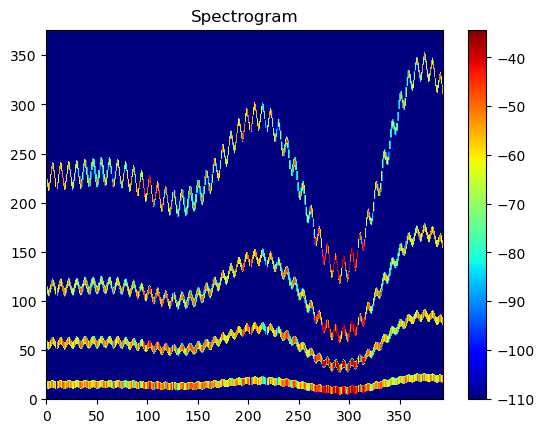

In [ ]:
plt.title('Spectrogram')
ax = plt.subplot()
im = ax.imshow(10 * ss[:375].log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
plt.colorbar(im, ax=ax)
print(ss.shape)

tensor([[ 2.4032,  1.3820,  1.0297,  ..., -0.4393,  0.4623, -1.8010]],
       device='cuda:0')


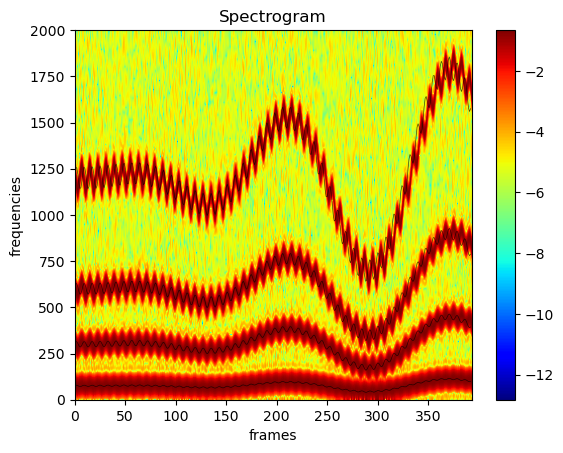

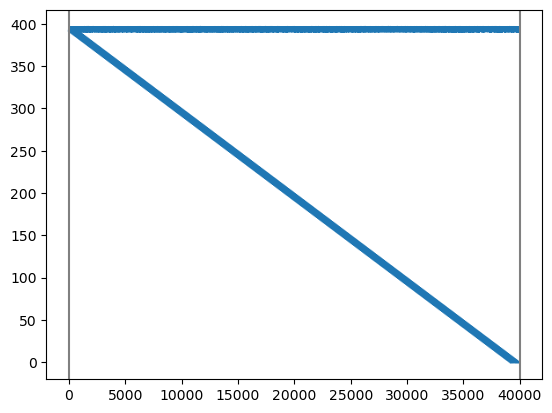

In [ ]:
print(x)
dstft = FDSTFT(x, 100,   support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None) #win_length=support - 100
spec, stft, real, imag, phase = dstft(x)
f_hat = torch.nn.functional.interpolate(f[None, None, None, :], size=spec.shape[-1], mode='bicubic')
f_hat = f_hat.squeeze()[0]
dstft.print(spec, weights=False, x=x, wins=True, bar=True, f_hat=[1.5*f_hat, 6*f_hat, 12*f_hat, 24*f_hat], fs=sr)
specs[650] = spec.cpu()

In [ ]:
print(spec.shape)

torch.Size([1, 376, 393])


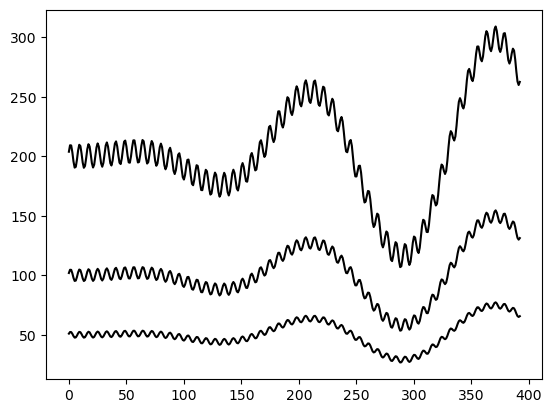

In [ ]:


plt.plot(1*f_hat, c='k')
plt.plot(2*f_hat, c='k')
plt.plot(4*f_hat, c='k')


In [ ]:
#dstft.print(specs['200'] - specs['650'], weights=False, wins=False, bar=True)

In [ ]:
#dstft.print(specs['650'] - specs['200'], weights=False, wins=False, bar=True)

In [ ]:
#dstft.print((specs['200'] - specs['650']).abs(), weights=False, wins=False, bar=True)

Single window length

Epoch 00013: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00023: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00033: reducing learning rate of group 0 to 1.0000e-01.
32
379.82122802734375 tensor(10.1953, device='cuda:0', grad_fn=<MeanBackward0>)


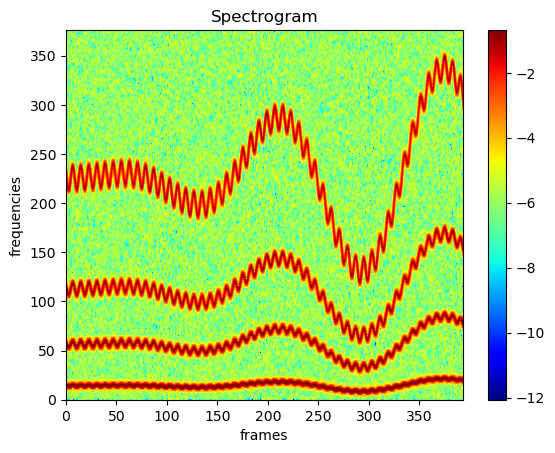

381.7


In [ ]:
dstft = FDSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
print(min_win, min_err)
dstft.print(spec, x, bar=True, wins=False, weights=False)
print(f'{dstft.win_length.item():.1f}')
specs[390] = spec.cpu()

Time-varying window length

Epoch 00017: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00041: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00051: reducing learning rate of group 0 to 1.0000e-01.
50


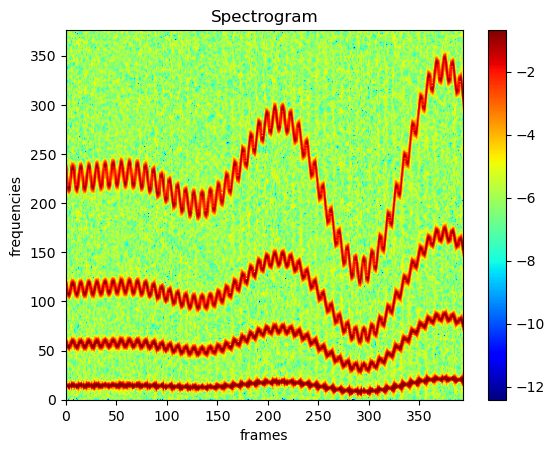

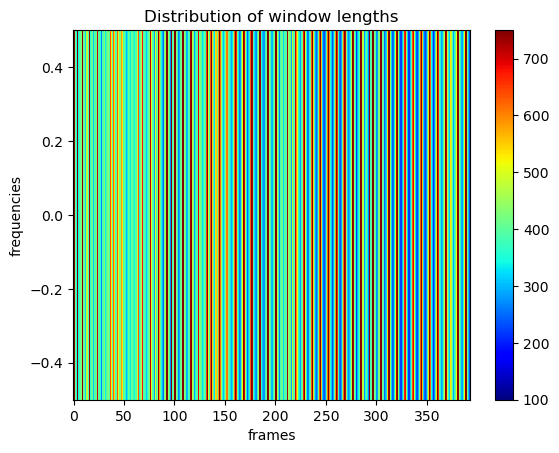

In [ ]:
dstft = FDSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
specs['t'] = spec.cpu()

Epoch 00045: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00077: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00094: reducing learning rate of group 0 to 1.0000e-01.
93


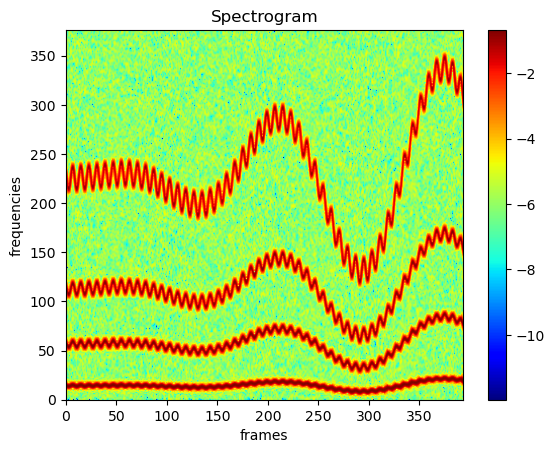

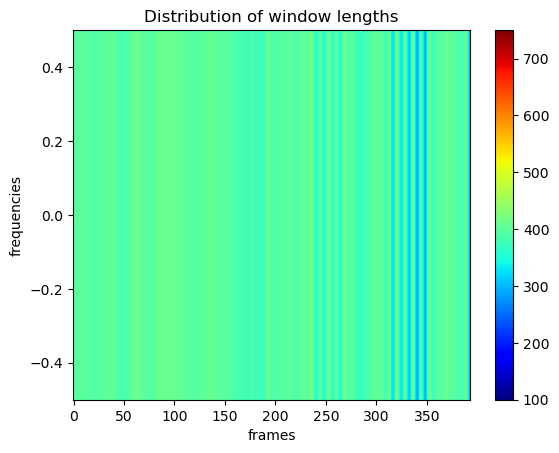

In [ ]:
dstft = FDSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.0005 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False)
specs['t2'] = spec.cpu()

Frequency-varying window length

In [ ]:
dstft = DSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)
specs['f'] = spec.cpu()

Epoch 00018: reducing learning rate of group 0 to 1.0000e+01.


KeyboardInterrupt: 

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


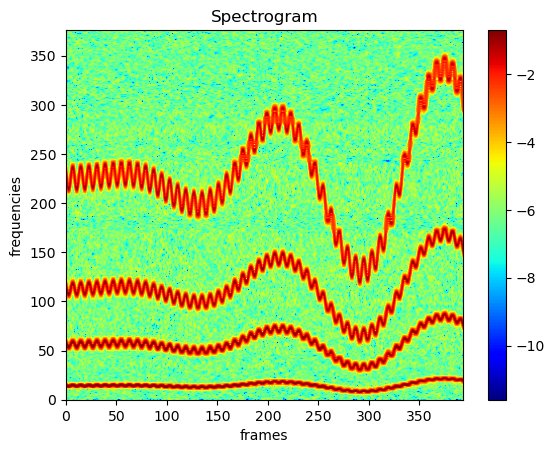

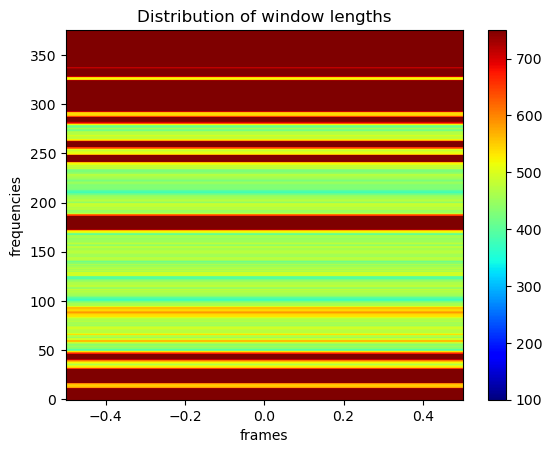

In [ ]:
dstft = DSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 10 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)
specs['f2'] = spec.cpu()

Time-and-frequency-varying window length

Epoch 00055: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00075: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00085: reducing learning rate of group 0 to 1.0000e-01.
84


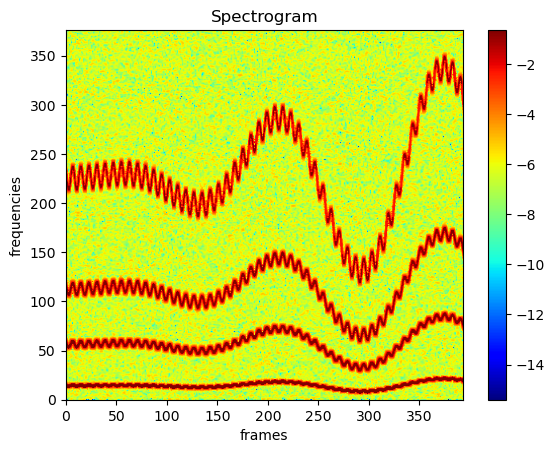

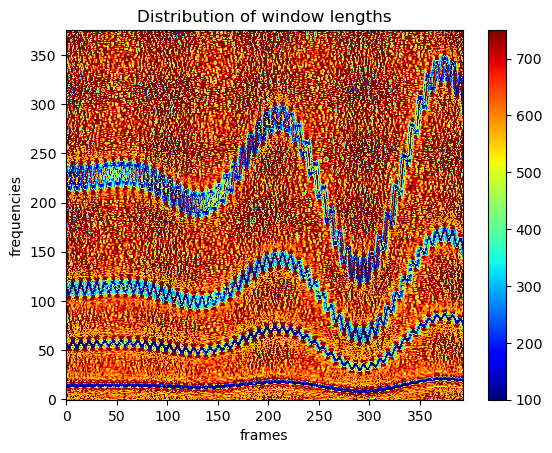

In [ ]:
dstft = DSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
specs['tf'] = spec.cpu()

Epoch 00106: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00153: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00168: reducing learning rate of group 0 to 1.0000e-01.
167


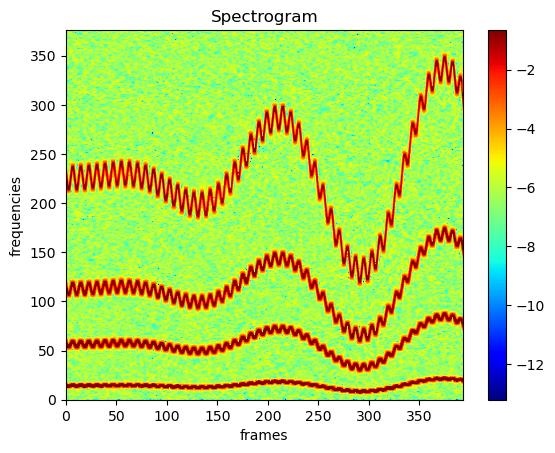

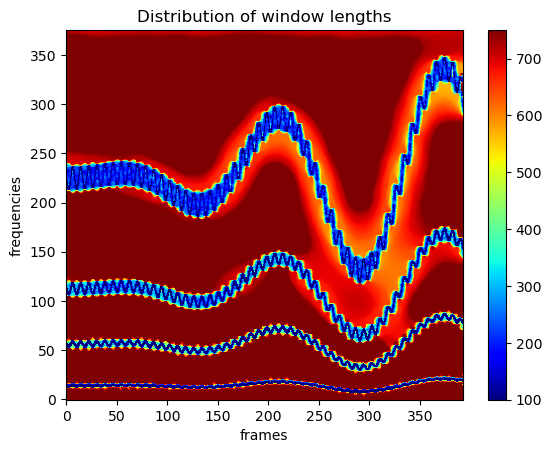

In [ ]:

dstft = DSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
specs['tf2'] = spec.cpu()

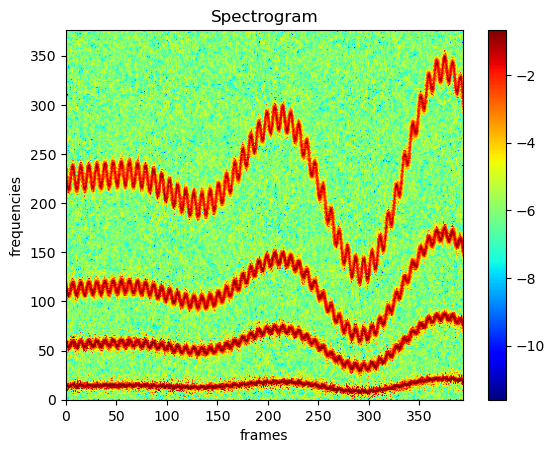

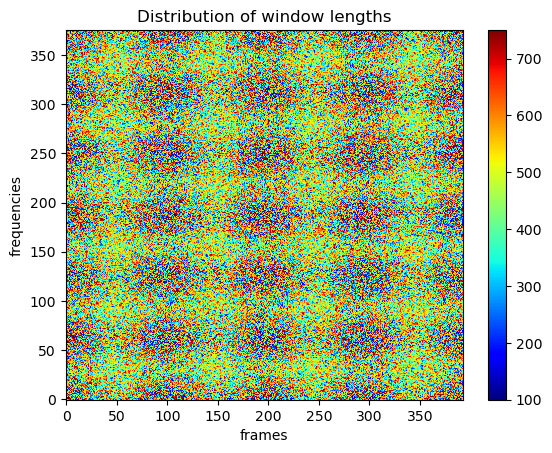

In [ ]:
dstft = DSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
dstft.win_length.data = dstft.win_min + dstft.win_max * torch.rand(dstft.win_length.size(), device=device)
spec, *_ = dstft(x)
dstft.print(spec, wins=False, bar=True)
specs['rand'] = spec.cpu()

In [ ]:
savemat('9_.mat', specs)

200
650
390


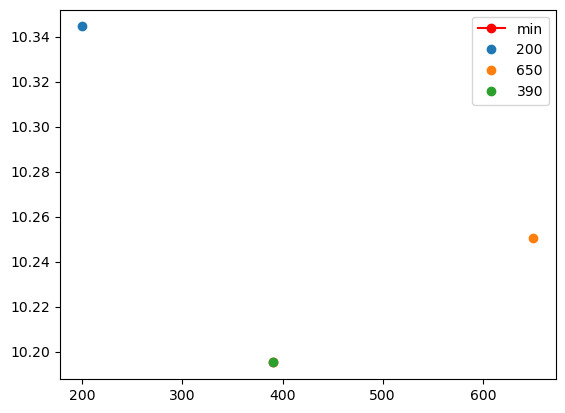

In [ ]:
losses = []
min_err = 100
min_win = 0
#print()

for win_length in range(100, support, 1):
    dstft = FDSTFT(x, win_length=win_length,   support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    losses.append(err.cpu())


#print(min_win, min_err)
#plt.plot(range(100, support, 1), losses, label='loss')
plt.plot(min_win, min_err.cpu(),  color='red', marker='o', label='min')
#plt.axvline(x=200, ymin=0.02, ymax=0.95,  color='green', linestyle ='--', label='100')
#plt.axvline(x=support-100, ymin=0.02, ymax=0.95,  color='orange', linestyle ='--', label='1000')


for key, spec in specs.items():
    print(key)
    if isinstance(key, int):
        plt.plot(key, entropy_loss(spec).detach(), 'o', label=key)
#plt.plot([200], entropy_loss(specs['200']), 'o', label=200)
#plt.plot([650], entropy_loss(specs['650']), 'o', label=650)
    

plt.legend()
plt.show()